# ReporterScreen sample / guide quality report

Examine the quality of the guide and samples and masks the low-quality guides and samples.

In [1]:
import perturb_tools as pt
import bean as be
import matplotlib.pyplot as plt
plt.style.use('default')

In [2]:
! jt -r

Reset css and font defaults in:
/PHShome/jr1025/.jupyter/custom &
/PHShome/jr1025/.local/share/jupyter/nbextensions


In [3]:
plt.style.use('default')

In [4]:
exp_id = "LDLRCDS"
save_format = "png"
bdata_path = "../results/mapped/LDLRCDS/bean_count_LDLRCDS_combined.h5ad"
out_bdata_path = "../results/mapped/LDLRCDS/bean_count_LDLRCDS_masked.h5ad"
edit_quantification_start_pos = 2
edit_quantification_end_pos = 7
corr_X_thres=0.7
edit_rate_thres=0.1
lfc_thres=-0.1
replicate_label="rep"
condition_label="bin"

In [5]:
# Parameters
bdata_path = "results/mapped/LDLvar/bean_count_LDLvar_combined.h5ad"
out_bdata_path = "results/filtered_annotated/LDLvar/bean_count_LDLvar_masked.h5ad"
edit_quantification_start_pos = 2
edit_quantification_end_pos = 7
corr_X_thres = 0.8
edit_rate_thres = 0.1
lfc_thres = -0.1
condition_label = "bin"


In [6]:
bdata = be.read_h5ad(bdata_path)

Annotate unannotated samples & log-normalize guides

In [7]:
bdata.samples[["rep", condition_label]] = bdata.samples.index.to_series().str.split("_", expand=True)

In [8]:
bdata.log_norm()

## Sample quality

### Visualize quality metrics

#### 1. Guide coverage

<AxesSubplot: title={'center': 'Guide coverage'}, xlabel='counts', ylabel='# guides'>

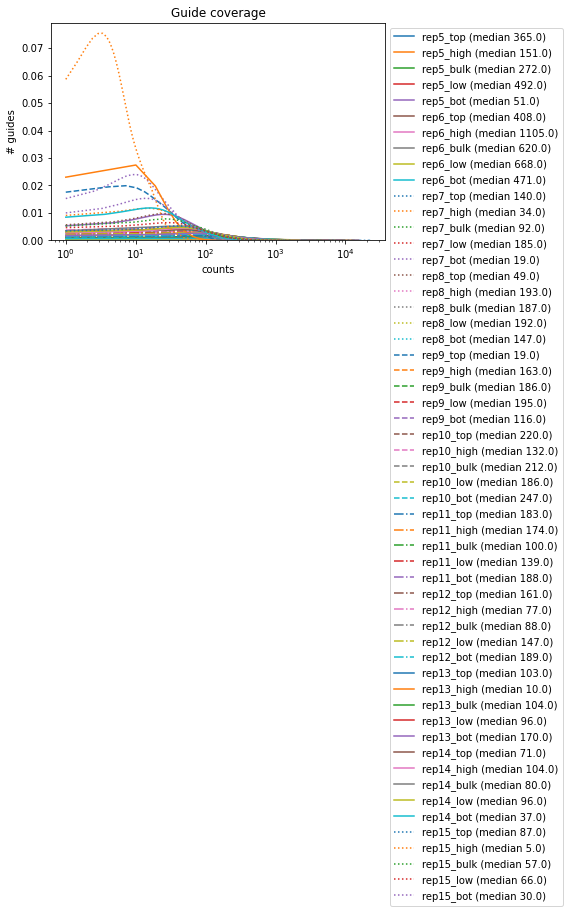

In [9]:
pt.qc.plot_guide_coverage(bdata, figsize=(6,4))


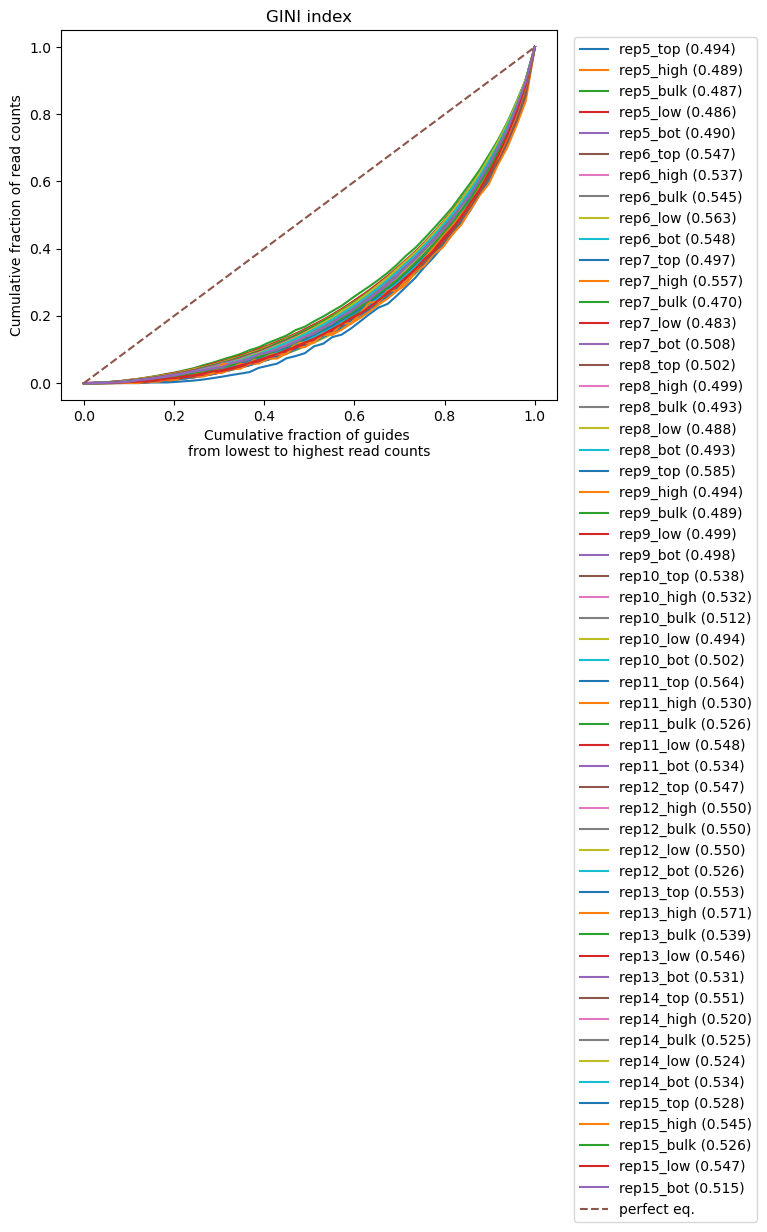

In [10]:
plt.style.use('default')
pt.qc.plot_X_gini(bdata)
plt.savefig(f"{exp_id}_gini.{save_format}")

#### 2. Guide abundance correlation

<AxesSubplot: title={'center': 'corr_X'}>

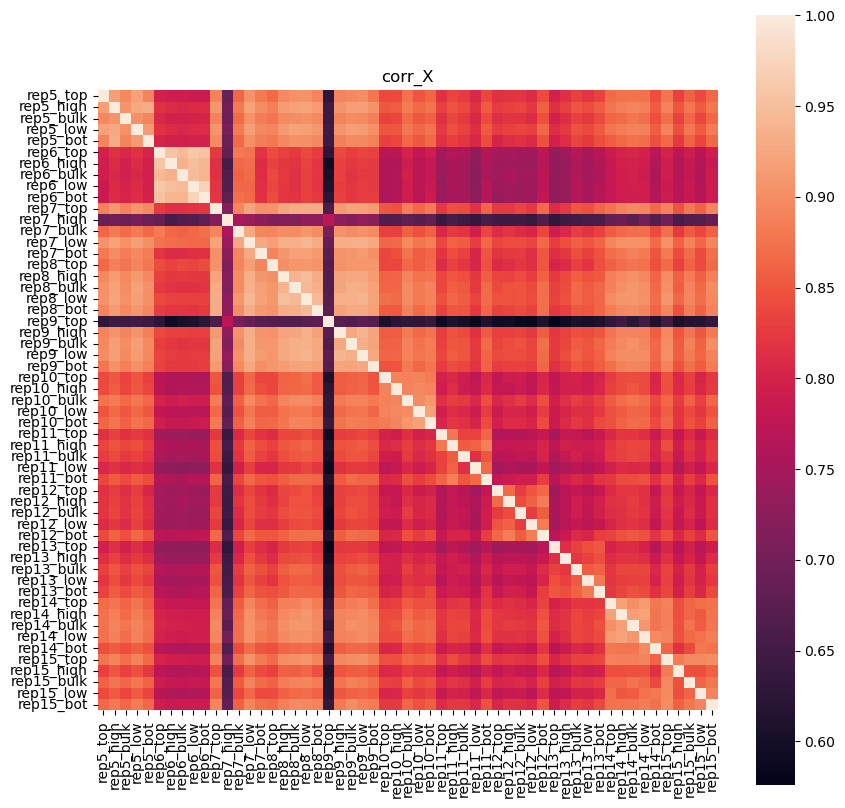

In [11]:
pt.qc.plot_correlation(bdata, "Spearman")

#### 3. LFC correlation of positive controls

In [12]:
lfcs = bdata[bdata.guides.Group == "PosCtrl",:].log_fold_change_reps(cond1="top", cond2="bot", rep_col="rep", compare_col=condition_label)

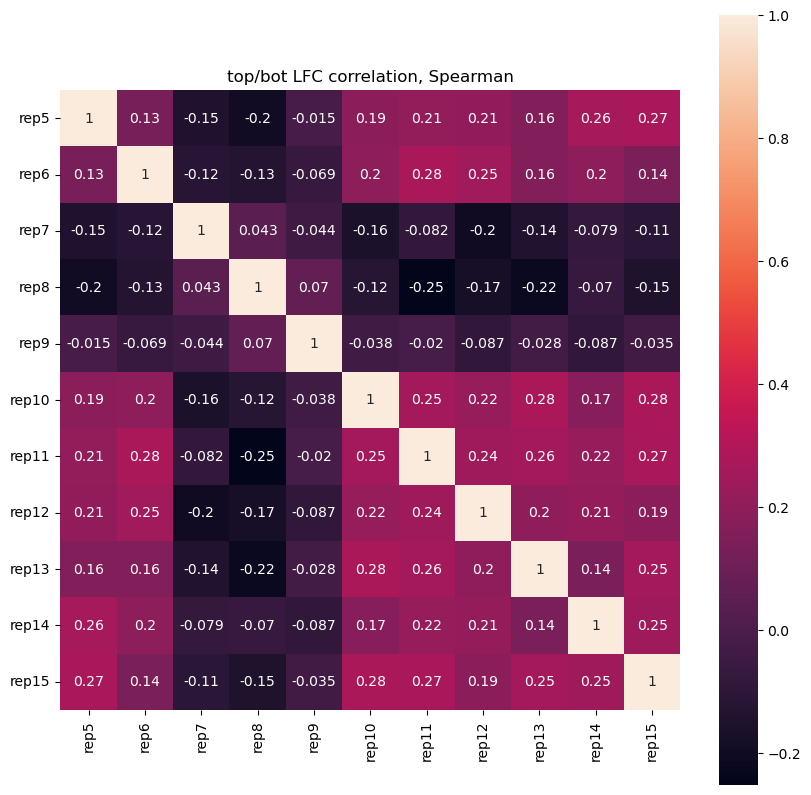

In [13]:
ax=pt.qc.plot_lfc_correlation(bdata, bdata.guides.Group == "PosCtrl", method="Spearman", cond1="top", cond2="bot", rep_col="rep", compare_col=condition_label, figsize=(10,10))

ax.set_title("top/bot LFC correlation, Spearman")
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

#### 4. Guide editing rates

In [14]:
bdata.uns['allele_counts'] = bdata.uns['allele_counts'].loc[bdata.uns['allele_counts'].allele.map(str) != ""]

New edit matrix saved in .layers['edits']. Returning old edits.


<AxesSubplot: xlabel='Editing rate', ylabel='Count'>

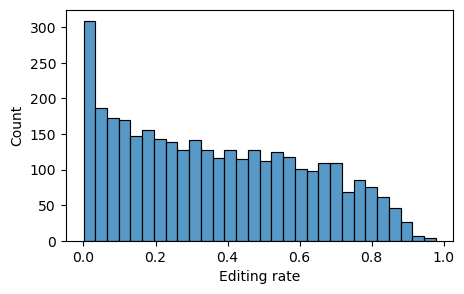

In [15]:
bdata.get_edit_from_allele()
bdata.get_edit_mat_from_uns(
    rel_pos_start=edit_quantification_start_pos, 
    rel_pos_end=edit_quantification_end_pos, 
    rel_pos_is_reporter=False
)
bdata.get_guide_edit_rate(
    editable_base_start = edit_quantification_start_pos, 
    editable_base_end=edit_quantification_end_pos)
be.qc.plot_guide_edit_rates(bdata)

<AxesSubplot: xlabel='Editing rate', ylabel='Density'>

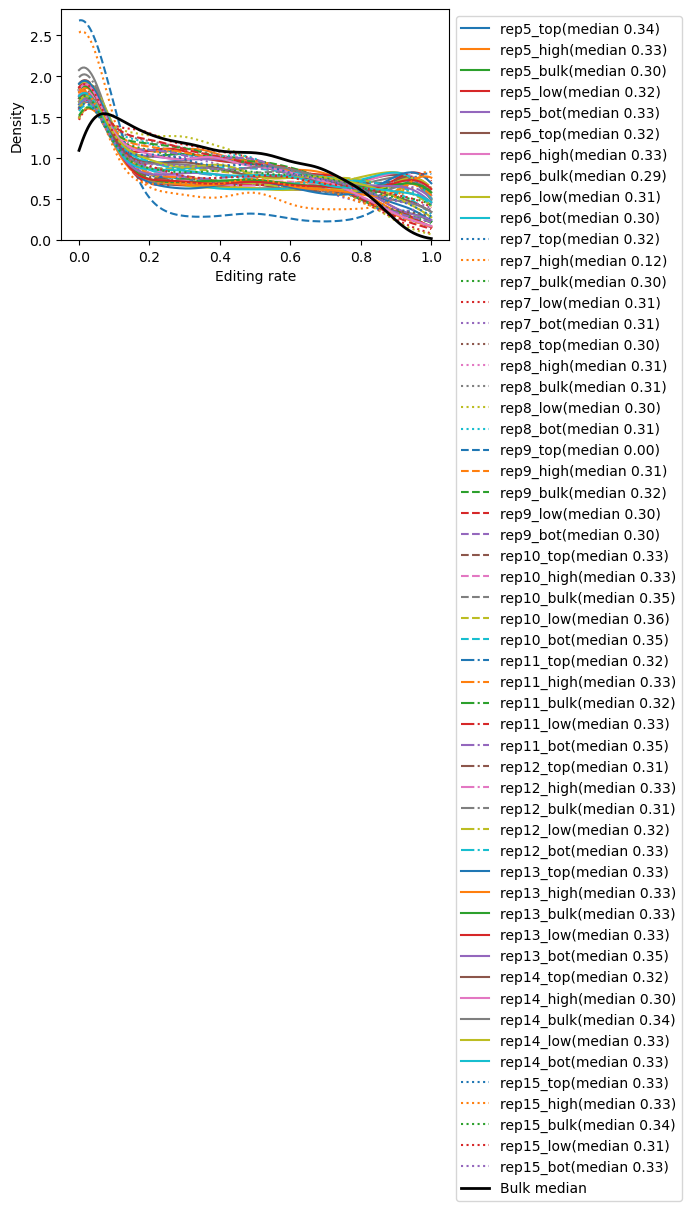

In [16]:
bdata.get_edit_rate(
    editable_base_start = edit_quantification_start_pos, 
    editable_base_end=edit_quantification_end_pos
)
be.qc.plot_sample_edit_rates(bdata)

### Mask low-quality samples

In [17]:
bdata.samples.style.background_gradient(cmap="coolwarm_r")

,bin,rep,gini_X,median_corr_X,median_lfc_corr.top_bot,median_editing_rate
rep5_top,top,rep5,0.493510,0.848909,0.186755,0.339147
rep5_high,high,rep5,0.488701,0.866966,0.186755,0.333333
rep5_bulk,bulk,rep5,0.486657,0.850945,0.186755,0.304582
rep5_low,low,rep5,0.486369,0.864541,0.186755,0.322271
rep5_bot,bot,rep5,0.489634,0.852060,0.186755,0.333333
rep6_top,top,rep6,0.546780,0.796851,0.159803,0.319277
rep6_high,high,rep6,0.536605,0.790187,0.159803,0.329041
rep6_bulk,bulk,rep6,0.545218,0.789376,0.159803,0.288397
rep6_low,low,rep6,0.562569,0.788251,0.159803,0.308665
rep6_bot,bot,rep6,0.547677,0.789220,0.159803,0.303136


Assign sample mask to mask low-quality samples.

In [18]:
bdata.samples['mask'] = 1
bdata.samples.loc[bdata.samples.median_corr_X < corr_X_thres, 'mask'] = 0
bdata.samples.loc[bdata.samples.median_editing_rate < edit_rate_thres, 'mask'] = 0
bdata = bdata[:, bdata.samples["median_lfc_corr.top_bot"] > lfc_thres]

In [19]:
# leave replicate with more than 1 sorting bin data
rep_n_samples = bdata.samples.groupby(replicate_label)['mask'].sum()
print(rep_n_samples)
rep_has_too_small_sample = rep_n_samples.loc[rep_n_samples < 2].index.tolist()
rep_has_too_small_sample
print(f"Excluding reps {rep_has_too_small_sample} that has less than 2 samples per replicate.")
bdata = bdata[:, ~bdata.samples[replicate_label].isin(rep_has_too_small_sample)]

rep
rep10    5
rep11    5
rep12    5
rep13    4
rep14    5
rep15    5
rep5     5
rep6     0
rep9     4
Name: mask, dtype: int64
Excluding reps ['rep6'] that has less than 2 samples per replicate.


In [20]:
bdata.samples.style.background_gradient(cmap="coolwarm_r")

,bin,rep,gini_X,median_corr_X,median_lfc_corr.top_bot,median_editing_rate,mask
rep5_top,top,rep5,0.493510,0.848909,0.186755,0.339147,1
rep5_high,high,rep5,0.488701,0.866966,0.186755,0.333333,1
rep5_bulk,bulk,rep5,0.486657,0.850945,0.186755,0.304582,1
rep5_low,low,rep5,0.486369,0.864541,0.186755,0.322271,1
rep5_bot,bot,rep5,0.489634,0.852060,0.186755,0.333333,1
rep9_top,top,rep9,0.584971,0.627554,-0.034763,0.000000,0
rep9_high,high,rep9,0.493625,0.866789,-0.034763,0.306250,1
rep9_bulk,bulk,rep9,0.489102,0.874705,-0.034763,0.319297,1
rep9_low,low,rep9,0.499184,0.878257,-0.034763,0.296296,1
rep9_bot,bot,rep9,0.498359,0.863626,-0.034763,0.303030,1


## Identify outlier guides

In [21]:
outlier_guides, mask = be.qc.get_outlier_guides_and_mask(bdata, condit_col = condition_label, replicate_col = "rep")

In [22]:
outlier_guides


,name,sample,RPM,rep
0,CONTROL_1_g3,rep9_top,43769.902344,rep9
1,LDLR_SA_1_g1,rep9_top,25234.220703,rep9
2,LDLR_SA_2_g1,rep9_top,54505.914062,rep9
3,LDLR_SA_2_g2,rep9_top,14498.206055,rep9
4,LDLR_SA_3_g2,rep9_top,19820.332031,rep9
5,LDLR_SA_4_g1,rep9_top,33400.929688,rep9
6,LDLR_SA_4_g2,rep9_top,28629.369141,rep9
7,LDLR_SA_4_g4,rep9_top,39457.144531,rep9
8,LDLR_SA_5_g2,rep9_top,36429.035156,rep9
9,LDLR_SA_6_g2,rep9_top,13305.315430,rep9


In [23]:
outlier_guides_n_samples = outlier_guides['name'].value_counts()
guides_to_exclude = outlier_guides_n_samples.loc[outlier_guides_n_samples > 2].index
guides_to_exclude

Index(['CONTROL_2_g5', 'rs3750944_Min_ABE_471_g2', 'rs34468565_Maj_ABE_170_g4',
       'rs2301249_Maj_ABE_145_g1'],
      dtype='object')

In [24]:
bdata.uns['repguide_mask'] = mask

In [25]:
bdata = bdata[~bdata.guides.index.isin(guides_to_exclude),:]

In [26]:
bdata

Genome Editing Screen comprised of n_guides x n_conditions = 3451 x 40
   guides:    'Unnamed: 0', 'Target gene/variant', 'Target descriptor', 'Arbitrary number', 'gRNA position category', 'Target base position in gRNA', 'Target base position in reporter', 'BE', 'Group', 'sequence', 'Reporter', 'barcode', '5-nt PAM', 'offset', 'target', 'target_pos', 'Group2', 'masked_sequence', 'masked_barcode', 'edit_rate'
   samples:   'bin', 'rep', 'gini_X', 'median_corr_X', 'median_lfc_corr.top_bot', 'median_editing_rate', 'mask'
   samples_m: 
   samples_p: 
   layers:    'X_bcmatch', 'edits', 'lognorm_counts', 'edit_rate', 'X_RPM'
   uns:       'allele_counts', 'edit_counts', 'target_base_change', 'tiling', 'lfc', 'lfc_corr', 'repguide_mask'

In [27]:
bdata.uns['repguide_mask'].shape

(3451, 8)

In [28]:
bdata.write(out_bdata_path)

... storing 'bin' as categorical
... storing 'rep' as categorical
